In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Adam, SGD
from keras.models import load_model

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('data/PUBG/train_V2.csv')
df_test = pd.read_csv('data/PUBG/test_V2.csv')

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory usage: 288.4+ MB


In [4]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
df_train = reduce_mem_usage(df_train)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory usage: 288.4+ MB


In [7]:
df_train.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


## Feature engineering

In [66]:
NUM = 0
import gc, sys

def feature_engineering(is_train=True):
    if is_train: 
        print("processing train.csv")
        df = df_train

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = df_test
    
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    if NUM > 0: df = df[:NUM]
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    
    features.remove("matchType")
    
    y = None
    
    print("get target")
    if is_train: 
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])

    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = np.array(df_out, dtype=np.float64)
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names

In [67]:
x_train, y_train, train_feature_names = feature_engineering(True)

processing train.csv
remove some columns
get target
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


## Data Scale

In [64]:
#scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=False).fit(x_train)
#scaler = preprocessing.QuantileTransformer().fit(x_train)

In [65]:
# print("x_train", x_train.shape, x_train.max(), x_train.min())
# scaler.transform(x_train)
# print("x_train", x_train.shape, x_train.max(), x_train.min())
# print("y_train", y_train.shape, y_train.max(), y_train.min())


x_train (2026744, 177) 41280.0 -1.0
x_train (2026744, 177) 41280.0 -1.0
y_train (2026744,) 1.0 0.0


## Model

In [83]:
model = Sequential()
model.add(Dense(32, kernel_initializer='normal', input_dim=x_train.shape[1], activation='softplus'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(32, kernel_initializer='normal', activation='softplus'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(32, kernel_initializer='normal', activation='softplus'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(1, kernel_initializer='normal', activation='softplus'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                5696      
_________________________________________________________________
batch_normalization_25 (Batc (None, 32)                128       
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_26 (Batc (None, 32)                128       
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                1056      
__________

In [84]:
LEARN_RATE = 0.01

model.compile(loss='mse', 
              #optimizer=Adam(lr=LEARN_RATE), # Adam optimizer with 1.0e-4 learning rate
              #optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-4, nesterov=True),
              #optimizer = optimizers.Adam(lr=0.01, epsilon=1e-8, decay=1e-4, amsgrad=False),
              optimizer='adam',
              metrics = ['mae'],
              )

In [85]:
NUM_EPOCH = 10

model_details = model.fit(x_train, y_train,
                    batch_size = 128,
                    epochs = NUM_EPOCH, # number of iterations
                    validation_split=0.10,
                    #callbacks=[checkpoint],
                    #callbacks=[lr_sched,early_stopping],
                    verbose=1)

Train on 1824069 samples, validate on 202675 samples
Epoch 1/10
1824069/1824069 [==============================] - 140s 77us/step - loss: 0.0080 - mean_absolute_error: 0.0679 - val_loss: 0.0065 - val_mean_absolute_error: 0.0601
Epoch 2/10
1824069/1824069 [==============================] - 138s 75us/step - loss: 0.0057 - mean_absolute_error: 0.0576 - val_loss: 0.0051 - val_mean_absolute_error: 0.0514
Epoch 3/10
1824069/1824069 [==============================] - 137s 75us/step - loss: 0.0052 - mean_absolute_error: 0.0549 - val_loss: 0.0048 - val_mean_absolute_error: 0.0522
Epoch 4/10
1824069/1824069 [==============================] - 137s 75us/step - loss: 0.0050 - mean_absolute_error: 0.0534 - val_loss: 0.0045 - val_mean_absolute_error: 0.0532
Epoch 5/10
1824069/1824069 [==============================] - 137s 75us/step - loss: 0.0048 - mean_absolute_error: 0.0521 - val_loss: 0.0044 - val_mean_absolute_error: 0.0509
Epoch 6/10
1824069/1824069 [==============================] - 140s 77us/

KeyError: 'val_acc'

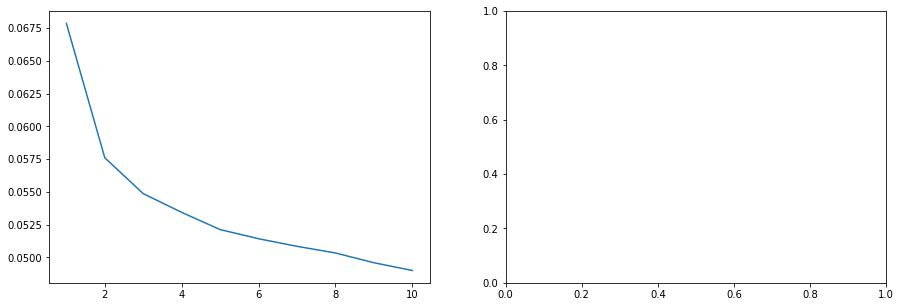

In [86]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for MAE
    axs[0].plot(range(1,len(model_details.history['mean_absolute_error'])+1),model_details.history['mean_absolute_error'])
    axs[0].plot(range(1,len(model_details.history['val_mean_absolute_error'])+1),model_details.history['val_mean_absolute_error'])
    axs[0].set_title('Model MAE')
    axs[0].set_ylabel('MAE')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['mean_absolute_error'])+1),len(model_details.history['mean_absolute_error'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()
plot_model(model_details)